# Random Forest Classification using the Credit Default Dataset

## Main plan:
1. Construct new features from features in the original dataset 
2. Construct a pipeline for Random Forest classification in sklearn
3. Compare the accuracy of the model with no custom features compared to *with* custom features

### Part 1: EDA and Feature Creation

In [1]:
#initial data import -
from pycaret.datasets import get_data
credit_original = get_data('credit') #skipping profile=True this time, since we've already explored the dataset a bit
credit_card = credit_original.copy() #making a copy to hold all of the new features

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,90000,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,50000,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,50000,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,50000,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


#### New features: 
***MAX/MIN/MEDIAN_PAY*** = max/min/median/mode PAY_AMT1-6

***MAX/MIN/MEDIAN_BILL*** = max/min/median/mode BILL_AMT1-6

***MAX_REL_PAY*** = max BILL_AMT1-6 / LIMIT_BAL

***MAX_REL_BILL*** = max BILL_AMT1-6 / LIMIT_BAL

* Basic fields that make sense to add - obviously high bills and low payments are a recipe for bad credit

#### New feature: ***UTIL*** (i.e. Utiliziation) = median BILL_AMT1-6 / LIMIT_BAL
* Hypothesis: those with high bills compared to their limit are likely pushing their credit cards and are thus *at higher risk of defaulting*

#### New feature: ***REL_PAY***  (i.e. Relative payment) = median PAY_AMT1-6 / LIMIT_BAL
* Hypothesis: anti-pattern to UTIL - those who have high payments are likely to be on top of their game, as far as payments go

#### New feature: ***PAY_OVER_BILL***  = REL_PAY / UTIL
* Hypothesis: intuitive column based on the other new features added - higher ratio of pay relative to bill should be indicative of someone who does not let their outstanding balance grow

In [2]:
bill_amts = credit_card.filter(items=credit_card[credit_card.columns[credit_card.columns.str.contains("BILL_AMT")]])
bill_amts.head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
0,3913.0,3102.0,689.0,0.0,0.0,0.0
1,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0
2,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0
3,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0
4,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0


In [3]:
pay_amts = credit_card.filter(items=credit_card[credit_card.columns[credit_card.columns.str.contains("PAY_AMT")]])
pay_amts.head()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.0,689.0,0.0,0.0,0.0,0.0
1,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
2,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
3,2000.0,36681.0,10000.0,9000.0,689.0,679.0
4,2500.0,1815.0,657.0,1000.0,1000.0,800.0


In [4]:
pay_amts.mode(axis=1).head()

,0,1,2,3,4,5
0,0.0,NaN,NaN,NaN,NaN,NaN
1,1000.0,NaN,NaN,NaN,NaN,NaN
2,1000.0,1069.0,1100.0,1200.0,2000.0,2019.0
3,679.0,689.0,2000.0,9000.0,10000.0,36681.0
4,1000.0,NaN,NaN,NaN,NaN,NaN


In [5]:
credit_card['MAX_PAY'] = pay_amts.max(axis=1)
credit_card['MAX_BILL'] = bill_amts.max(axis=1)
credit_card['MIN_PAY'] = pay_amts.min(axis=1)
credit_card['MIN_BILL'] = bill_amts.min(axis=1)
credit_card['MEDIAN_PAY'] = pay_amts.median(axis=1)
credit_card['MEDIAN_BILL'] = bill_amts.median(axis=1)
credit_card["REL_PAY"] = credit_card['MEDIAN_PAY']/credit_card["LIMIT_BAL"]
credit_card['UTIL'] = credit_card['MEDIAN_BILL']/credit_card["LIMIT_BAL"]
credit_card['MAX_REL_PAY'] = credit_card['MAX_PAY'] / credit_card['LIMIT_BAL']
credit_card['MAX_REL_BILL'] = credit_card['MAX_BILL'] / credit_card['LIMIT_BAL']
credit_card["PAY_OVER_BILL"] = credit_card["REL_PAY"] / credit_card["UTIL"]
credit_card.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,MAX_BILL,MIN_PAY,MIN_BILL,MEDIAN_PAY,MEDIAN_BILL,REL_PAY,UTIL,MAX_REL_PAY,MAX_REL_BILL,PAY_OVER_BILL
0,20000,2,2,1,24,2,2,-1,-1,-2,...,3913.0,0.0,0.0,0.0,344.5,0.000000,0.017225,0.034450,0.195650,0.000000
1,90000,2,2,2,34,0,0,0,0,0,...,29239.0,1000.0,13559.0,1250.0,14639.5,0.013889,0.162661,0.055556,0.324878,0.085385
2,50000,2,2,1,37,0,0,0,0,0,...,49291.0,1000.0,28314.0,1150.0,38268.5,0.023000,0.765370,0.040380,0.985820,0.030051
3,50000,1,2,1,57,-1,0,-1,0,0,...,35835.0,679.0,5670.0,5500.0,19138.5,0.110000,0.382770,0.733620,0.716700,0.287379
4,50000,1,1,2,37,0,0,0,0,0,...,64400.0,657.0,19394.0,1000.0,38546.5,0.020000,0.770930,0.050000,1.288000,0.025943


#### New feature: ***SPEND_AMT*** (SPEND_AMT(X) = -(BILL_AMT(X+1) - BILL_AMT(X) - PAY_AMT(X))
* The SPEND_AMT column is just an intuitive column to add that accounts for any unpaid balance between months
    * *There will of course be no data for SPEND_AMT6*

#### New features: 
***MAX/MIN/MEDIAN_SPEND*** = max/min/median/mode SPEND_AMT1-5

* Basic fields that make sense to add - obviously high bills and low payments are a recipe for bad credit

#### New feature: ***REL_SPEND*** (i.e. relative spending) = median SPEND_AMT1-5 / LIMIT_BAL
* Hypothesis: similar idea to new UTIL column

#### New feature: ***STD_SPEND*** = stdev SPEND_AMT1-6 / LIMIT_BAL

In [6]:
for i in range(1,6):
    credit_card[f"SPEND_AMT{i}"] = -(credit_card[f"BILL_AMT{i+1}"] - credit_card[f"BILL_AMT{i}"] - credit_card[f"PAY_AMT{i}"])

In [7]:
spend_amts = credit_card.filter(items=credit_card[credit_card.columns[credit_card.columns.str.contains("SPEND_AMT")]])
credit_card["MAX_SPEND"] = spend_amts.max(axis=1)
credit_card["MIN_SPEND"] = spend_amts.min(axis=1)
credit_card["MEDIAN_SPEND"] = spend_amts.median(axis=1)
credit_card["REL_SPEND"] = credit_card["MEDIAN_SPEND"]/credit_card["LIMIT_BAL"]
credit_card["STD_SPEND"] = spend_amts.std(axis=1)/credit_card["LIMIT_BAL"]
credit_card.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,SPEND_AMT1,SPEND_AMT2,SPEND_AMT3,SPEND_AMT4,SPEND_AMT5,MAX_SPEND,MIN_SPEND,MEDIAN_SPEND,REL_SPEND,STD_SPEND
0,20000,2,2,1,24,2,2,-1,-1,-2,...,811.0,3102.0,689.0,-0.0,-0.0,3102.0,-0.0,689.0,0.034450,0.063832
1,90000,2,2,2,34,0,0,0,0,0,...,16730.0,1968.0,228.0,383.0,399.0,16730.0,228.0,399.0,0.004433,0.079823
2,50000,2,2,1,37,0,0,0,0,0,...,757.0,961.0,22177.0,455.0,481.0,22177.0,455.0,757.0,0.015140,0.192468
3,50000,1,2,1,57,-1,0,-1,0,0,...,4947.0,6516.0,24895.0,10794.0,704.0,24895.0,704.0,6516.0,0.130320,0.185919
4,50000,1,1,2,37,0,0,0,0,0,...,9831.0,1276.0,38871.0,775.0,595.0,38871.0,595.0,1276.0,0.025520,0.329069


#### New feature: ***MAX_DELAY***  = max PAY1-6

#### New feature: ***MEDIAN_DELAY***  = median PAY1-6

* Hypothesis for both: high delays in payment indicate bad credit behavior - aggregation is useful given the existing high correlation between these related variables

** First, PAY1-6 must be "fixed", as values below 0 have no difference to 0

In [8]:
credit_card.columns[credit_card.columns.str.contains("PAY_[1-9]")]

Index(['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], dtype='object')

In [9]:
for column in credit_card.columns[credit_card.columns.str.contains("PAY_[1-9]")]:
    credit_card[column] = credit_card[column].apply(lambda x: 0 if x<=0 else x)    
credit_card.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,SPEND_AMT1,SPEND_AMT2,SPEND_AMT3,SPEND_AMT4,SPEND_AMT5,MAX_SPEND,MIN_SPEND,MEDIAN_SPEND,REL_SPEND,STD_SPEND
0,20000,2,2,1,24,2,2,0,0,0,...,811.0,3102.0,689.0,-0.0,-0.0,3102.0,-0.0,689.0,0.034450,0.063832
1,90000,2,2,2,34,0,0,0,0,0,...,16730.0,1968.0,228.0,383.0,399.0,16730.0,228.0,399.0,0.004433,0.079823
2,50000,2,2,1,37,0,0,0,0,0,...,757.0,961.0,22177.0,455.0,481.0,22177.0,455.0,757.0,0.015140,0.192468
3,50000,1,2,1,57,0,0,0,0,0,...,4947.0,6516.0,24895.0,10794.0,704.0,24895.0,704.0,6516.0,0.130320,0.185919
4,50000,1,1,2,37,0,0,0,0,0,...,9831.0,1276.0,38871.0,775.0,595.0,38871.0,595.0,1276.0,0.025520,0.329069


In [10]:
pay_delays = credit_card.filter(items=credit_card[credit_card.columns[credit_card.columns.str.contains("PAY_[1-9]")]])
pay_delays.head()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,2,2,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [11]:
credit_card["MAX_DELAY"] = pay_delays.max(axis=1)
credit_card["MEDIAN_DELAY"] = pay_delays.median(axis=1)
credit_card.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,SPEND_AMT3,SPEND_AMT4,SPEND_AMT5,MAX_SPEND,MIN_SPEND,MEDIAN_SPEND,REL_SPEND,STD_SPEND,MAX_DELAY,MEDIAN_DELAY
0,20000,2,2,1,24,2,2,0,0,0,...,689.0,-0.0,-0.0,3102.0,-0.0,689.0,0.034450,0.063832,2,0.0
1,90000,2,2,2,34,0,0,0,0,0,...,228.0,383.0,399.0,16730.0,228.0,399.0,0.004433,0.079823,0,0.0
2,50000,2,2,1,37,0,0,0,0,0,...,22177.0,455.0,481.0,22177.0,455.0,757.0,0.015140,0.192468,0,0.0
3,50000,1,2,1,57,0,0,0,0,0,...,24895.0,10794.0,704.0,24895.0,704.0,6516.0,0.130320,0.185919,0,0.0
4,50000,1,1,2,37,0,0,0,0,0,...,38871.0,775.0,595.0,38871.0,595.0,1276.0,0.025520,0.329069,0,0.0


** NOTE: in most of these cases, **median** is being used because the data tends to be skewed

#### New feature: ***STD_BILL***  = stdev BILL_AMT1-6 / LIMIT_BAL
* Hypothesis: the higher the number here, the more erratic the bill is - could indicate a person who is in the process of over-charging their credit card (but depends on their payments)

#### New feature: ***STD_PAY***  = stdev PAY_AMT1-6 / LIMIT_BAL
* Hypothesis: similar to STD_BILL, but with a twist - erratically *high* payments are encouraged

#### New feature: ***STD_PAY_OVER_BILL***  = STD_PAY / STD_BILL

In [12]:
credit_card["STD_BILL"] = bill_amts.std(axis=1) / credit_card['LIMIT_BAL']
credit_card["STD_PAY"] = pay_amts.std(axis=1) / credit_card['LIMIT_BAL']
credit_card["STD_PAY_OVER_BILL"] = credit_card["STD_PAY"] / credit_card["STD_BILL"]
credit_card.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,MAX_SPEND,MIN_SPEND,MEDIAN_SPEND,REL_SPEND,STD_SPEND,MAX_DELAY,MEDIAN_DELAY,STD_BILL,STD_PAY,STD_PAY_OVER_BILL
0,20000,2,2,1,24,2,2,0,0,0,...,3102.0,-0.0,689.0,0.034450,0.063832,2,0.0,0.088082,0.014064,0.159672
1,90000,2,2,2,34,0,0,0,0,0,...,16730.0,228.0,399.0,0.004433,0.079823,0,0.0,0.067384,0.017442,0.258852
2,50000,2,2,1,37,0,0,0,0,0,...,22177.0,455.0,757.0,0.015140,0.192468,0,0.0,0.211316,0.009561,0.045246
3,50000,1,2,1,57,0,0,0,0,0,...,24895.0,704.0,6516.0,0.130320,0.185919,0,0.0,0.213372,0.275725,1.292226
4,50000,1,1,2,37,0,0,0,0,0,...,38871.0,595.0,1276.0,0.025520,0.329069,0,0.0,0.441379,0.014279,0.032350


#### New feature: ***BILL_PROGRESS***  = 
`function: if abs(BILL_AMT1 - BILL_AMT6) > mean BILL_AMT1-6 + or - 1 STD`

`then: "major" change, else: "minor" change`

`if BILL_AMT1 - BILL_AMT6 < 0: "good", else "bad"`
* Hypothesis: people whose balance as of 1 month ago is significantly greater than their balance as of 6 months ago are just accruing debt and not in a great spot as far as defaulting goes

In [13]:
#bill_amts.T.describe()[0]

In [14]:
#bill_amts.iloc[0].map(lambda x: x > bill_amts.iloc[0].quantile(.75)).sum()

In [15]:
### This will have 5 categories from 2 to -2:
# 2: Major increase, 1: minor increase, 0: no change, -1: minor decrease, -2: major decrease
def progress(row):
    row_diff_bill = row['BILL_AMT1'] - row['BILL_AMT6']
    row_bill_amts = row[row.index[row.index.str.contains('BILL_AMT')]]
    if row_diff_bill == 0:
        return 0
    elif (abs(row_diff_bill) > row_bill_amts.mean() + row['STD_BILL']) or (abs(row_diff_bill) < row_bill_amts.mean() - row['STD_BILL']):
        if row_diff_bill < 0:
            return -2
        else:
            return 2
    else:
        if row_diff_bill < 0:
            return -1
        else:
            return 1

credit_card['BILL_PROGRESS'] = credit_card.apply(lambda row: progress(row), axis=1)

#### New feature: ***BILL_OUTLIER***  = 
`function: if a row contains a BILL_AMT > Q3 of BILL_AMT1-6 + IQR * 1.5, return 1`
* Hypothesis: though we only have 6 months of data to work with, maybe there's a scenario where a person made 1 (or more) *big* purchase(s) that led to them defaulting - this will quantify such purchases using a simple outlier method

In [16]:
### This will have 2 categories:
# 0: no major buys, 1: at least 1 major buy
def outlier(row):
    row_bill_amts = row[row.index[row.index.str.contains('BILL_AMT')]]
    q3 = row_bill_amts.quantile(.75)
    q1 = row_bill_amts.quantile(.25)
    iqr = q3 - q1 
    outlier_threshold = q3 + 1.5 * iqr
    total = row_bill_amts.map(lambda x: x > outlier_threshold).sum()
    if total > 0:
        return 1
    else:
        return 0
    
credit_card['BILL_OUTLIERS'] = credit_card.apply(lambda row: outlier(row), axis=1)

#### New feature: ***RETIRED***  = 1 if AGE > 66, otherwise 0
* Hypothesis: online resources indicate the age of retirement in Taiwan is 66 (as of 2015) - retirees likely have different, safer credit profiles than non-retirees

#### New feature: ***SINGLE_MOM***  = 1 if MARRIAGE = 2 and SEX = 2, otherwise 0
* Hypothesis: single moms traditionally have a harder burden to bear, financially and emotionally, and this might reflect in their default rate

** At the same time, consider that single parents receive special subsidies and financial aid (at least in the US)

In [17]:
credit_card["RETIRED"] = credit_card["AGE"].apply(lambda x: 1 if x > 66 else 0)

def single_mom(x,y):
    if x == 2 and y == 2:
        return 1
    else:
        return 0
    
credit_card["SINGLE_MOM"] = credit_card[['SEX', 'MARRIAGE']].apply(lambda x: single_mom(*x), axis=1)
credit_card.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,STD_SPEND,MAX_DELAY,MEDIAN_DELAY,STD_BILL,STD_PAY,STD_PAY_OVER_BILL,BILL_PROGRESS,BILL_OUTLIERS,RETIRED,SINGLE_MOM
0,20000,2,2,1,24,2,2,0,0,0,...,0.063832,2,0.0,0.088082,0.014064,0.159672,2,0,0,0
1,90000,2,2,2,34,0,0,0,0,0,...,0.079823,0,0.0,0.067384,0.017442,0.258852,2,1,0,1
2,50000,2,2,1,37,0,0,0,0,0,...,0.192468,0,0.0,0.211316,0.009561,0.045246,2,0,0,0
3,50000,1,2,1,57,0,0,0,0,0,...,0.185919,0,0.0,0.213372,0.275725,1.292226,-2,1,0,0
4,50000,1,1,2,37,0,0,0,0,0,...,0.329069,0,0.0,0.441379,0.014279,0.032350,2,0,0,0


#### Feature repair: 
***EDUCATION***: consolidate values > 4 into 4

***MARRIAGE***: combine rows where MARRIAGE = 3 or 0 into 3

In [18]:
credit_card['MARRIAGE'] = credit_card['MARRIAGE'].apply(lambda x: 3 if x in [0,3] else x)
credit_card['EDUCATION'] = credit_card['EDUCATION'].apply(lambda x: 4 if x > 4 else x)
credit_card.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,STD_SPEND,MAX_DELAY,MEDIAN_DELAY,STD_BILL,STD_PAY,STD_PAY_OVER_BILL,BILL_PROGRESS,BILL_OUTLIERS,RETIRED,SINGLE_MOM
0,20000,2,2,1,24,2,2,0,0,0,...,0.063832,2,0.0,0.088082,0.014064,0.159672,2,0,0,0
1,90000,2,2,2,34,0,0,0,0,0,...,0.079823,0,0.0,0.067384,0.017442,0.258852,2,1,0,1
2,50000,2,2,1,37,0,0,0,0,0,...,0.192468,0,0.0,0.211316,0.009561,0.045246,2,0,0,0
3,50000,1,2,1,57,0,0,0,0,0,...,0.185919,0,0.0,0.213372,0.275725,1.292226,-2,1,0,0
4,50000,1,1,2,37,0,0,0,0,0,...,0.329069,0,0.0,0.441379,0.014279,0.032350,2,0,0,0


In [19]:
credit_card.iloc[3].T

LIMIT_BAL            50000.000000
SEX                      1.000000
EDUCATION                2.000000
MARRIAGE                 1.000000
AGE                     57.000000
PAY_1                    0.000000
PAY_2                    0.000000
PAY_3                    0.000000
PAY_4                    0.000000
PAY_5                    0.000000
PAY_6                    0.000000
BILL_AMT1             8617.000000
BILL_AMT2             5670.000000
BILL_AMT3            35835.000000
BILL_AMT4            20940.000000
BILL_AMT5            19146.000000
BILL_AMT6            19131.000000
PAY_AMT1              2000.000000
PAY_AMT2             36681.000000
PAY_AMT3             10000.000000
PAY_AMT4              9000.000000
PAY_AMT5               689.000000
PAY_AMT6               679.000000
default                  0.000000
MAX_PAY              36681.000000
MAX_BILL             35835.000000
MIN_PAY                679.000000
MIN_BILL              5670.000000
MEDIAN_PAY            5500.000000
MEDIAN_BILL   

#### ** Interesting Note:
The training dataframe that pycaret uses in the `setup` phase is available if assigned to a variable, and from this info it looks like Pycaret *did not* throw away the "grouped" features of `PAY_AMT` and `BILL_AMT`...

Given that those groups were highly correlated amongst each other, the original model used in the Anomaly Detection experiment could have some artifacts/not been as effective as it could have been.

For this reason, we'll be *explicitly* dropping those columns in *this* analysis.

In [20]:
import seaborn as sns

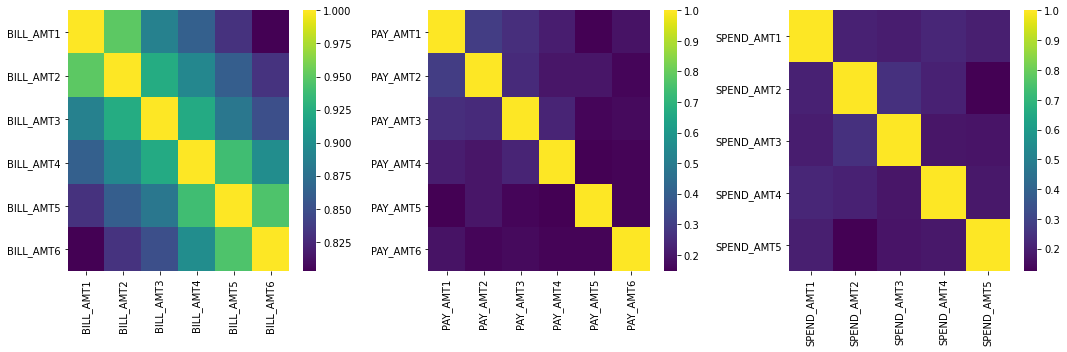

In [21]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
sns.heatmap(bill_amts.corr(), cmap='viridis', ax=ax1)
sns.heatmap(pay_amts.corr(), cmap='viridis', ax=ax2)
sns.heatmap(spend_amts.corr(), cmap='viridis', ax=ax3)

fig.tight_layout()
plt.show()

** **Note above**: only `BILL_AMT1-6` have high colinearity, while `SPEND_AMT` and `PAY_AMT` are less egregious...

In [22]:
new_columns = credit_card.drop(columns=credit_original.columns).shape[1]
print(f"# of New Features added: {new_columns}")

# of New Features added: 30


<AxesSubplot:>

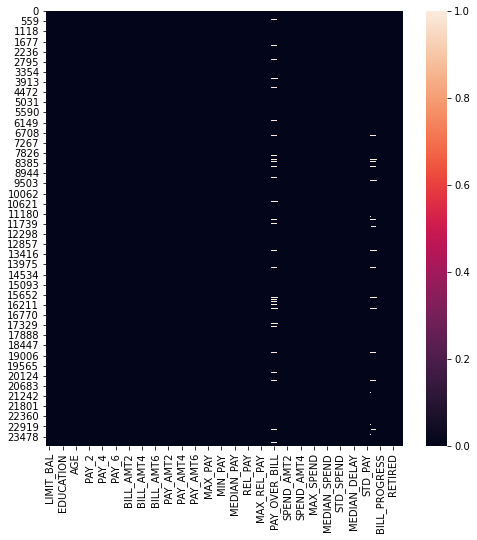

In [23]:
## final cleanup/data investigation
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(credit_card.isna(), ax=ax)

In [24]:
trouble_columns = ['UTIL', 'REL_PAY', 'PAY_OVER_BILL', 'STD_BILL', 'STD_PAY', 'STD_PAY_OVER_BILL']
null_frame = credit_card[credit_card.isnull().any(axis=1)]
null_frame[trouble_columns].head()

,UTIL,REL_PAY,PAY_OVER_BILL,STD_BILL,STD_PAY,STD_PAY_OVER_BILL
7,0.0,0.0,NaN,0.347817,0.261887,0.752944
15,0.0,0.0,NaN,0.000000,0.000000,NaN
16,0.0,0.0,NaN,0.000000,0.000000,NaN
33,0.0,0.0,NaN,0.006369,0.006369,1.000000
50,0.0,0.0,NaN,0.298925,0.008165,0.027314


In [25]:
credit_card.loc[23931,].T

LIMIT_BAL            150000.00000
SEX                       1.00000
EDUCATION                 2.00000
MARRIAGE                  1.00000
AGE                      35.00000
PAY_1                     1.00000
PAY_2                     0.00000
PAY_3                     0.00000
PAY_4                     0.00000
PAY_5                     0.00000
PAY_6                     0.00000
BILL_AMT1               -18.00000
BILL_AMT2               -18.00000
BILL_AMT3               -18.00000
BILL_AMT4               -18.00000
BILL_AMT5               -18.00000
BILL_AMT6               -18.00000
PAY_AMT1                  0.00000
PAY_AMT2                  0.00000
PAY_AMT3                  0.00000
PAY_AMT4                  0.00000
PAY_AMT5                  0.00000
PAY_AMT6                  0.00000
default                   0.00000
MAX_PAY                   0.00000
MAX_BILL                -18.00000
MIN_PAY                   0.00000
MIN_BILL                -18.00000
MEDIAN_PAY                0.00000
MEDIAN_BILL   

Based on the above, looks like we're working with some nulls in the new features due to a few weirdos having pristine/non-existent bills or payments. **All resulting** `NaN` **values will be converted to 0.**

Negative `UTIL` is also a unique observation, wherein an individual have a negative balance, but does not cause an issue for the analysis.

<AxesSubplot:>

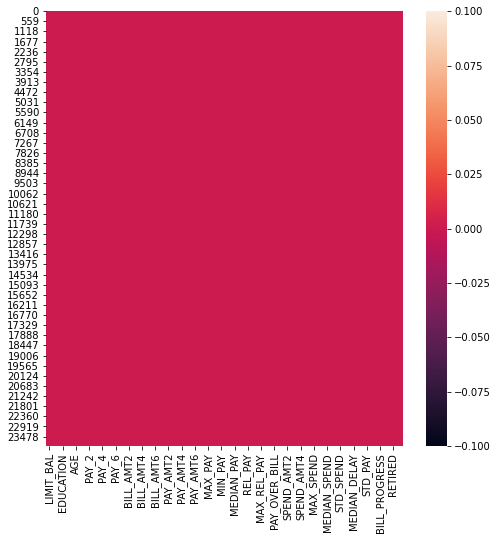

In [26]:
## cleanup nulls and run the heatmap once more to confirm
credit_card.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(credit_card.isna(), ax=ax)

#### What a perfect opportunity to create a new feature!

#### New feature: ***NEVER_PAID*** = 1 if PAY_AMT1-6 == 0 AND any(BILL_AMT1-6) > 0
* Hypothesis: these individuals would constitute those people who were negligent on their credit payments, and possibly defaulted as a result

In [27]:
import numpy as np
credit_card['NEVER_PAID'] = np.logical_and(pay_amts.sum(axis=1)==0, bill_amts.sum(axis=1)>0)

In [28]:
## referencing an older temp dataframe to expedite the process
credit_card = credit_card.drop(columns=bill_amts.columns)
## we will do the same for the original, untouched dataset
## NEVERMIND - this is not doable since we need the columns alive in order to use setup's "group_feature" arg
#credit_original = credit_original.drop(columns=bill_amts.columns)

## Part 2: Pycaret testing

There will be two experiments setup here:
1. Classification via the base `credit` data as packaged in Pycaret (with a few tweaks)
2. Classification via the modified `credit_card` data generated above

Note of course that many columns will remain unchanged between the two datasets - the hypothesis is that the model built on the more "sophisticated" dataset will yield a higher model accuracy (AUC)

*Additionally*, these same two experiments will also be performed "manually" through `sklearn` without the auto-ML features of Pycaret. Though Pycaret uses `sklearn` pipelines under-the-hood, using `sklearn` *directly* will allow a higher granularity of modifications to be performed to the pipeline, greater visibility into the processes in each step of the pipeline, and greater control of pipeline intermediates.

In all cases, an effort will be made to keep the input datasets **identical** (or as identical as possible).

In [29]:
#create unseen/test dataset from 20% of original
credit_train = credit_card.sample(frac=0.8, random_state=123)
credit_test = credit_card.drop(credit_train.index)
credit_train.reset_index(drop=True, inplace=True)
credit_test.reset_index(drop=True, inplace=True)

credit_orig_train = credit_original.sample(frac=0.8, random_state=123)
credit_orig_test = credit_original.drop(credit_orig_train.index)
credit_orig_train.reset_index(drop=True, inplace=True)
credit_orig_test.reset_index(drop=True, inplace=True)

credit_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,MAX_DELAY,MEDIAN_DELAY,STD_BILL,STD_PAY,STD_PAY_OVER_BILL,BILL_PROGRESS,BILL_OUTLIERS,RETIRED,SINGLE_MOM,NEVER_PAID
0,140000,2,2,2,35,0,0,0,0,0,...,0,0.0,0.022051,0.002416,0.109560,-2,0,0,1,False
1,40000,2,3,1,24,1,8,7,6,5,...,8,5.5,0.031174,0.000000,0.000000,2,0,0,0,True
2,50000,1,3,1,51,0,0,0,0,0,...,0,0.0,0.320344,0.333806,1.042024,2,1,0,0,False
3,90000,2,1,2,29,0,0,0,0,0,...,0,0.0,0.031156,0.028691,0.920873,2,0,0,1,False
4,50000,1,2,3,52,0,0,0,0,0,...,0,0.0,0.442017,0.011843,0.026794,2,0,0,0,False


In [30]:
credit_orig_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,140000,2,2,2,35,0,0,0,0,0,...,93606.0,95301.0,96653.0,3280.0,4270.0,3500.0,3606.0,3500.0,3550.0,0
1,40000,2,3,1,24,1,8,7,6,5,...,24579.0,23635.0,22680.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,50000,1,3,1,51,-1,-1,-1,-1,-1,...,8500.0,0.0,0.0,13902.0,42863.0,8500.0,0.0,0.0,0.0,0
3,90000,2,1,2,29,-1,-1,-1,-1,0,...,3199.0,1888.0,0.0,6198.0,200.0,3199.0,0.0,0.0,0.0,0
4,50000,1,2,3,52,0,0,0,0,0,...,10683.0,9953.0,9567.0,2500.0,1500.0,1300.0,800.0,1000.0,1500.0,0


In [70]:
from pycaret.classification import *
credit_setup = setup(credit_train,
                      target='default',
                      normalize=True, #default normalization uses z-score -> instead I will try "robust" method for outliers
                      normalize_method='robust',
                      #transformation=True, #leaving this off for now - it will transform data closer to Gaussian
                      #pca=True, #not enabling this as we are not working with a high enough dimensional space
                      remove_perfect_collinearity=True,
                      #ignore_low_variance=True,
                      #combine_rare_levels=True,
                      remove_multicollinearity=True,
                      create_clusters=True, #interesting additional feature that will add clustering group as a feature
                      feature_selection=True,
                      #feature_interaction=False, #interesting, but will not use for now, same with feature_ratio
                      bin_numeric_features=['LIMIT_BAL','AGE'],
                      session_id=1212
                    )  

,Description,Value
0,session_id,1212
1,Target,default
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(19200, 49)"
5,Missing Values,False
6,Numeric Features,33
7,Categorical Features,15
8,Ordinal Features,False
9,High Cardinality Features,False


### Setup explanation:
- `normalize=True` + `normalize_method='robust'`: Normalization is a given for certain algorithms, the only modification here was to use `'robust'` instead of the standard Z-score method because supposedly this method is better at normalizing outliers
- `transformation=False` (default): Normally this setting would convert skewed data to look more Gaussian, but I feel like that would negatively impact several features (such as PAY_AMT)
- `ignore_low_variance=False` (default): At best, the low variance features can still provide *some* weight to the model
- `feature_selection=True` + `feature_selection_threshold=0.8` (default): Feature selection is turned on, not changing the default rate, in order to constrain the feature space and potentially improve model performance
- `create_clusters=True`: One of Pycaret's more obfuscated features, but adds a cluster label to each sample (row) as an additional modeling feature
- `bin_numeric_features=['LIMIT_BAL','AGE"]`: Again, using the same binning that was done in the last exercise. This time, however, we will explicitly look at the bins that were created

In [71]:
import pandas as pd #only need this to run a type check
## some comprehension in order to extract the training dataset that was created in "setup"
setup_frame = [x for x in credit_setup if type(x) == pd.core.frame.DataFrame and x.shape[0] == 13439]
setup_frame = pd.DataFrame(setup_frame[0])
setup_frame.head()

,PAY_6_3,PAY_1_6,REL_PAY,REL_SPEND,SINGLE_MOM_1,AGE_7.0,MARRIAGE_2,LIMIT_BAL_1.0,MIN_BILL,SEX_1,...,MAX_DELAY_4,LIMIT_BAL_13.0,SPEND_AMT3,PAY_5_2,LIMIT_BAL_9.0,PAY_2_5,MAX_DELAY_7,MAX_REL_PAY,MAX_DELAY_0,PAY_4_4
11772,0.0,0.0,0.684986,-0.051295,1.0,0.0,1.0,0.0,2.829324,0.0,...,0.0,0.0,0.020981,0.0,0.0,0.0,0.0,-0.111474,0.0,0.0
3388,0.0,0.0,1.636405,5.195324,0.0,0.0,1.0,0.0,0.039239,1.0,...,0.0,0.0,-0.169414,0.0,0.0,0.0,0.0,7.685886,1.0,0.0
17008,0.0,0.0,0.023129,-0.349175,0.0,0.0,1.0,0.0,-0.047388,1.0,...,0.0,0.0,-0.156854,0.0,0.0,0.0,0.0,-0.091526,1.0,0.0
590,0.0,0.0,-0.693882,-0.516830,0.0,0.0,0.0,1.0,-0.210280,0.0,...,0.0,0.0,-0.278456,0.0,0.0,0.0,0.0,0.009610,1.0,0.0
9778,0.0,0.0,-0.693882,-0.420535,0.0,0.0,1.0,0.0,-0.210280,1.0,...,0.0,0.0,-0.116463,0.0,0.0,0.0,0.0,-0.538938,1.0,0.0


In [72]:
setup_frame.columns.difference(credit_train.columns)

Index(['AGE_0.0', 'AGE_1.0', 'AGE_10.0', 'AGE_11.0', 'AGE_12.0', 'AGE_14.0',
       'AGE_2.0', 'AGE_3.0', 'AGE_4.0', 'AGE_5.0', 'AGE_6.0', 'AGE_7.0',
       'AGE_8.0', 'AGE_9.0', 'BILL_OUTLIERS_0', 'BILL_PROGRESS_-1',
       'BILL_PROGRESS_-2', 'BILL_PROGRESS_0', 'BILL_PROGRESS_1',
       'BILL_PROGRESS_2', 'EDUCATION_0', 'EDUCATION_1', 'EDUCATION_2',
       'EDUCATION_3', 'EDUCATION_4', 'LIMIT_BAL_0.0', 'LIMIT_BAL_1.0',
       'LIMIT_BAL_10.0', 'LIMIT_BAL_11.0', 'LIMIT_BAL_12.0', 'LIMIT_BAL_13.0',
       'LIMIT_BAL_14.0', 'LIMIT_BAL_2.0', 'LIMIT_BAL_3.0', 'LIMIT_BAL_4.0',
       'LIMIT_BAL_5.0', 'LIMIT_BAL_6.0', 'LIMIT_BAL_7.0', 'LIMIT_BAL_8.0',
       'LIMIT_BAL_9.0', 'MARRIAGE_2', 'MARRIAGE_3', 'MAX_DELAY_0',
       'MAX_DELAY_1', 'MAX_DELAY_2', 'MAX_DELAY_3', 'MAX_DELAY_4',
       'MAX_DELAY_5', 'MAX_DELAY_6', 'MAX_DELAY_7', 'MAX_DELAY_8',
       'NEVER_PAID_False', 'PAY_1_0', 'PAY_1_1', 'PAY_1_2', 'PAY_1_3',
       'PAY_1_4', 'PAY_1_5', 'PAY_1_6', 'PAY_1_8', 'PAY_2_0', 'PAY_2_1',


#### Observations on Pycaret modifications:
1. `AGE` and `LIMIT_BAL` binned, as given per setup arguments
2. `BILL_PROGRESS`, `EDUCATION`, `MAX_DELAY`, and all `PAY_X` all converted to binary maps
3. `RETIRED`, `SEX`, and `SINGLE_MOM` converted to dummy variables
4. `data_cluster` column added due to the `create_cluster=True` argument

<AxesSubplot:title={'center':'Original training dataset LIMIT_BAL binning'}, ylabel='Frequency'>

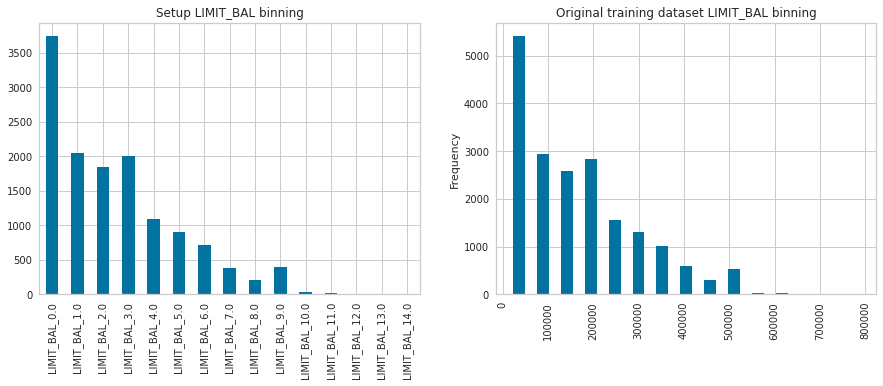

In [73]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
setup_limit_bal = setup_frame[setup_frame.columns[setup_frame.columns.str.contains('LIMIT_BAL')]]
## needlessly complex code in order to sort the new "LIMIT_BAL" bins and visualize them
setup_limit_bal[sorted(setup_limit_bal.columns.values, key=lambda x: float(x.split('_')[2]))].sum().plot.bar(
    title='Setup LIMIT_BAL binning', 
    ax=ax1)
credit_train['LIMIT_BAL'].plot.hist(bins=15, rot=90, rwidth=.5, title='Original training dataset LIMIT_BAL binning', ax=ax2)

In [74]:
## any column can be used here, as groupby is agnostic
#setup_frame.groupby('data_cluster_0')['BILL_PROGRESS_0'].count().plot.bar()

\** **NOTE:** Originally, the code above worked because Pycaret created a `data_cluster_0` feature due to `create_cluster=True` in the setup - the distribution was *nearly* all samples going to a single cluster.

What I suspect is that since most samples cluster together, the built-in clustering algo isn't able to separate them enough.

Also ***weird*** is that Pycaret, in different setup configurations, adds different numbers of new features... This is clearly based on the input sample being different, but raise questions about the setup being tractable to different inputs.

In [75]:
common_col = setup_frame.columns.intersection(credit_train.columns)

<AxesSubplot:>

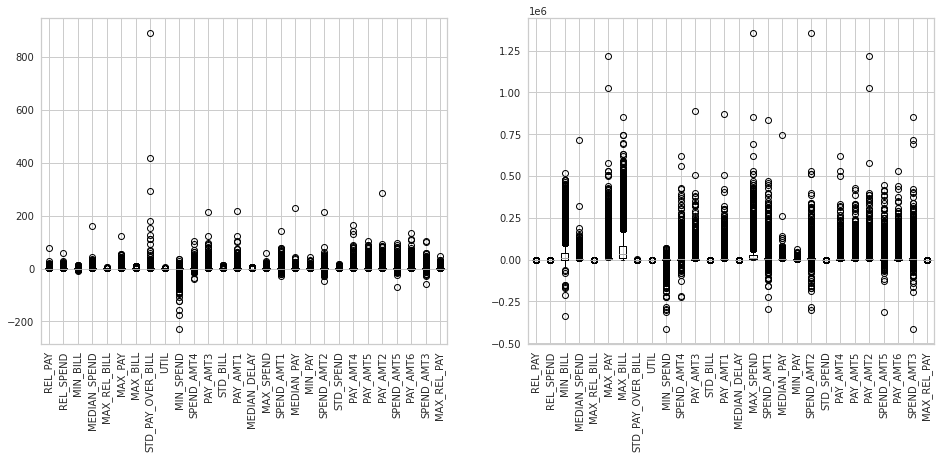

In [76]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
setup_frame[common_col].boxplot(ax=ax1, rot=90)
credit_train[common_col].boxplot(ax=ax2, rot=90)

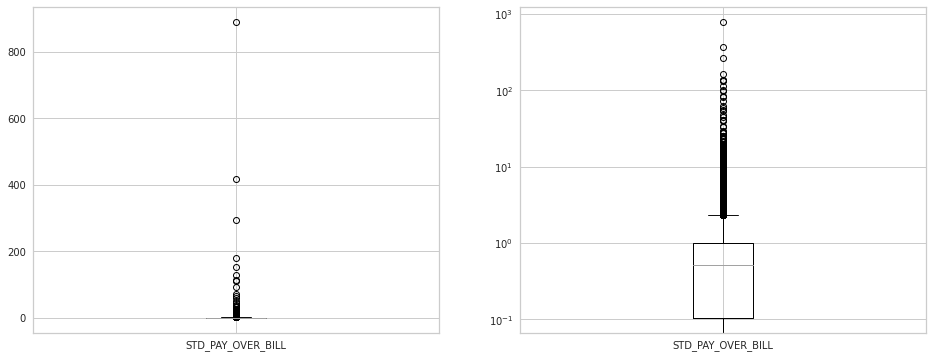

In [77]:
## just confirming how the normalization worked during the setup step
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
setup_frame.boxplot(column=['STD_PAY_OVER_BILL'], ax=ax1)
credit_train.boxplot(column=['STD_PAY_OVER_BILL'], ax=ax2)
plt.yscale('log')

In [78]:
## saving this for later so that credit_train_orig can be easily compared
prepare_pipe = get_config('prep_pipe')
prepare_pipe.named_steps

{'dtypes': DataTypes_Auto_infer(categorical_features=[], display_types=True,
                      features_todrop=[], id_columns=[],
                      ml_usecase='classification', numerical_features=[],
                      target='default', time_features=[]),
 'imputer': Simple_Imputer(categorical_strategy='not_available',
                fill_value_categorical=None, fill_value_numerical=None,
                numeric_strategy='mean', target_variable=None),
 'new_levels1': New_Catagorical_Levels_in_TestData(replacement_strategy='least frequent',
                                    target='default'),
 'ordinal': 'passthrough',
 'cardinality': 'passthrough',
 'znz': 'passthrough',
 'club_R_L': 'passthrough',
 'new_levels': New_Catagorical_Levels_in_TestData(replacement_strategy='least frequent',
                                    target='default'),
 'feature_time': Make_Time_Features(list_of_features=None,
                    time_feature=Index([], dtype='object')),
 'group': 'pas

In [79]:
credit_rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8088,0.7635,0.3633,0.6229,0.4589,0.3524,0.3713
1,0.8132,0.7738,0.3967,0.6296,0.4867,0.3797,0.3948
2,0.8118,0.7544,0.3933,0.6243,0.4826,0.3747,0.3897
3,0.8185,0.7773,0.3667,0.6707,0.4741,0.3756,0.4007
4,0.8118,0.7623,0.3733,0.6328,0.4696,0.3643,0.3830
5,0.8207,0.7908,0.4247,0.6480,0.5131,0.4090,0.4227
6,0.8162,0.7316,0.3612,0.6585,0.4665,0.3667,0.3909
7,0.8229,0.7655,0.3913,0.6763,0.4958,0.3975,0.4194
8,0.8289,0.7881,0.4047,0.6994,0.5127,0.4178,0.4408
9,0.8183,0.7589,0.3679,0.6667,0.4741,0.3752,0.3995


In [80]:
credit_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1212, verbose=0,
                       warm_start=False)

#### Important decision on which metric to use for scoring

##### Classic metrics:
- Accuracy: `TP + TN / total`
- Precison: `TP / (TP + FP)`
- Recall: `TP / (TP + FN)`
- F1: harmonic mean of *Precision* and *Recall*
- AUC: `TPR / FPR`

Given how the problem/use-case is phrased, there are different considerations for which metric is most useful, for example...

--------

1. If we use this model to **determine whether a person should be given a high or low line of credit**, or relatedly if they should be given a high or low credit *rate*, then consider the following FP and FN scenarios:

> The model gives a *bad* credit line to a *good* candidate (**FN**) --> **Not a big deal** - the candidate can request a better line or keep their (already) good credit score going to increase their line in the future

> The model gives a *good* credit line to a *bad* candidate (**FP**) --> **Also not a big deal** - the candidate will not make full use of their credit and might even have an easier time paying interest, while the risk of default is more or less the same

Since neither category is favored, and our data is only *mildly* imbalanced (not to mention that modeling is done via *stratified* k-folds), then **AUC** seems like a good choice for optimization.

--------

2. If we use this model to **determine whether a person can open an account *at all***, then consider how the scenarios change:

> The model *denies* credit to a *good* candidate (**FN**) --> **Not a huge deal** - we *are* potentially losing business, but this is only temporary; the candidate can reapply or return with a better credit history

> The model *grants* credit to a *bad* candidate (**FP**) --> **BAD** - assuming that this bad candidate has a risk of defaulting, *we* take on that risk and pay the consequences if it happens

Given the increased penalty for FP, we could choose to optimize on **Precision**, which factors in FP in the denominator.

In [81]:
tuned_rf = tune_model(credit_rf,
                      return_tuner=True,
                      tuner_verbose=True,
                      optimize='AUC'
                     )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8103,0.7809,0.3567,0.6331,0.4563,0.3521,0.3733
1,0.8170,0.7969,0.3900,0.6500,0.4875,0.3845,0.4030
2,0.8192,0.7780,0.4067,0.6524,0.5010,0.3978,0.4144
3,0.8311,0.7775,0.4100,0.7110,0.5201,0.4264,0.4502
4,0.8147,0.7894,0.3500,0.6604,0.4575,0.3583,0.3846
5,0.8304,0.7941,0.4281,0.6919,0.5289,0.4324,0.4509
6,0.8132,0.7479,0.3445,0.6519,0.4508,0.3509,0.3769
7,0.8222,0.7779,0.3712,0.6852,0.4816,0.3855,0.4119
8,0.8333,0.8044,0.3913,0.7358,0.5109,0.4216,0.4522
9,0.8191,0.7725,0.3612,0.6750,0.4706,0.3733,0.3999


In [82]:
get_config('fold_generator')

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [83]:
#get_config('X_train')

#### Built-in Pycaret tuning parameter grid:
```python
        tune_grid = {
            "n_estimators": np_list_arange(10, 300, 10, inclusive=True),
            "max_depth": np_list_arange(1, 11, 1, inclusive=True),
            "min_impurity_decrease": [
                0,
                0.0001,
                0.001,
                0.01,
                0.0002,
                0.002,
                0.02,
                0.0005,
                0.005,
                0.05,
                0.1,
                0.2,
                0.3,
                0.4,
                0.5,
            ],
            "max_features": [1.0, "sqrt", "log2"],
            "bootstrap": [True, False],
        }
        tune_distributions = {
            "n_estimators": IntUniformDistribution(10, 300),
            "max_depth": IntUniformDistribution(1, 11),
            "min_impurity_decrease": UniformDistribution(0.000000001, 0.5, log=True),
            "max_features": UniformDistribution(0.4, 1),
        }
        .
        .
        .
        if gpu_imported:
            tune_grid["split_criterion"] = [0, 1]
        else:
            tune_grid["criterion"] = ["gini", "entropy"]
            tune_grid["class_weight"] = ["balanced", "balanced_subsample", {}]
            tune_grid["min_samples_split"] = [2, 5, 7, 9, 10]
            tune_grid["min_samples_leaf"] = [2, 3, 4, 5, 6]
            tune_distributions["min_samples_split"] = IntUniformDistribution(2, 10)
            tune_distributions["min_samples_leaf"] = IntUniformDistribution(2, 6)
```

Just for curiosity, trying another search_library, **Optuna**, below

Unclear what, if any, advantages it has over the default `scikit-learn` library used by Pycaret...

In [84]:
optuna_tuned_rf = tune_model(credit_rf,
                             search_library='optuna',
                             return_tuner=True,
                             tuner_verbose=True,
                             optimize='AUC'
                            )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8118,0.7821,0.3467,0.6460,0.4512,0.3498,0.3745
1,0.8155,0.8005,0.3800,0.6477,0.4790,0.3760,0.3957
2,0.8222,0.7804,0.4167,0.6614,0.5112,0.4093,0.4257
3,0.8266,0.7805,0.3900,0.7006,0.5011,0.4063,0.4318
4,0.8155,0.7950,0.3567,0.6605,0.4632,0.3636,0.3888
5,0.8281,0.7972,0.4214,0.6848,0.5217,0.4241,0.4427
6,0.8155,0.7522,0.3445,0.6645,0.4537,0.3559,0.3837
7,0.8222,0.7788,0.3645,0.6899,0.4770,0.3819,0.4102
8,0.8318,0.8045,0.3846,0.7325,0.5044,0.4147,0.4460
9,0.8176,0.7723,0.3612,0.6667,0.4685,0.3700,0.3953


In [85]:
optuna_tuned_rf

(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                        criterion='gini', max_depth=6,
                        max_features=0.7767170789028999, max_leaf_nodes=None,
                        max_samples=None,
                        min_impurity_decrease=4.653288843215937e-06,
                        min_impurity_split=None, min_samples_leaf=3,
                        min_samples_split=3, min_weight_fraction_leaf=0.0,
                        n_estimators=276, n_jobs=-1, oob_score=False,
                        random_state=1212, verbose=0, warm_start=False),
 OptunaSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                enable_pruning=False, error_score='raise',
                estimator=Pipeline(memory=None,
                                   steps=[('empty_step', 'passthrough'),
                                          ('actual_estimator',
                                           RandomForestClassifier(boots

In [86]:
## can use this to take a peek under the hood at what metrics are being used for optimization
## as well as the `scorer` being used (part of scikit-learn)
#get_metrics()

In [87]:
tuned_rf[1]

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('empty_step', 'passthrough'),
                                             ('actual_estimator',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
                                                                     max_sam

At this point, it should be possible to create a *complete* pipeline, from data cleanup to Random Forest classication, by combining the `Pipeline` objects created in previous steps...

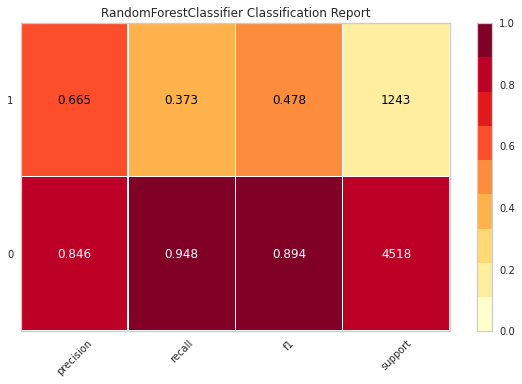

In [88]:
plot_model(tuned_rf[0], plot='class_report')

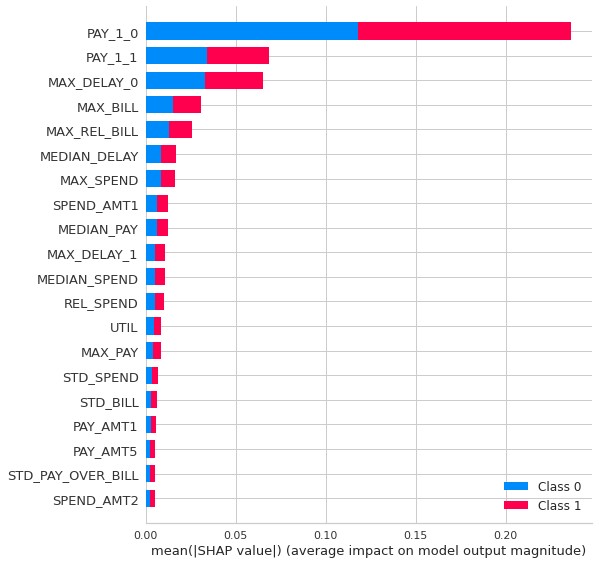

In [89]:
interpret_model(tuned_rf[0])

In [90]:
predict_model(tuned_rf[0])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8242,0.7786,0.3733,0.6648,0.4781,0.3822,0.4053


,PAY_6_3,PAY_1_6,REL_PAY,REL_SPEND,SINGLE_MOM_1,AGE_7.0,MARRIAGE_2,LIMIT_BAL_1.0,MIN_BILL,SEX_1,...,PAY_5_2,LIMIT_BAL_9.0,PAY_2_5,MAX_DELAY_7,MAX_REL_PAY,MAX_DELAY_0,PAY_4_4,default,Label,Score
0,0.0,0.0,0.202382,-0.230290,1.0,0.0,1.0,0.0,-0.030838,0.0,...,1.0,0.0,0.0,0.0,0.167798,0.0,0.0,0,1,0.6323
1,0.0,0.0,0.847692,0.059520,0.0,0.0,1.0,0.0,0.180071,1.0,...,1.0,0.0,0.0,0.0,0.686448,0.0,0.0,0,0,0.8406
2,0.0,0.0,-0.044090,3.903152,0.0,0.0,1.0,1.0,0.281489,1.0,...,0.0,0.0,0.0,0.0,7.493726,1.0,0.0,0,0,0.8921
3,0.0,0.0,-0.693882,-0.516830,0.0,0.0,0.0,0.0,-0.210280,1.0,...,0.0,0.0,0.0,0.0,0.971364,1.0,0.0,1,0,0.8474
4,0.0,0.0,-0.472953,-0.339065,0.0,0.0,0.0,0.0,-0.179090,0.0,...,0.0,0.0,0.0,0.0,-0.520763,1.0,0.0,1,0,0.8445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5756,0.0,0.0,-0.588980,-0.516830,1.0,0.0,1.0,0.0,-0.210280,0.0,...,0.0,0.0,0.0,0.0,-0.562483,1.0,0.0,0,0,0.8200
5757,0.0,0.0,0.890713,4.880322,0.0,0.0,1.0,0.0,0.059311,1.0,...,0.0,0.0,0.0,0.0,6.929695,1.0,0.0,0,0,0.8429
5758,0.0,0.0,-0.693882,-0.516830,0.0,0.0,0.0,0.0,-0.210280,1.0,...,0.0,0.0,0.0,0.0,-0.610176,1.0,0.0,0,0,0.8052
5759,0.0,0.0,0.395405,3.626948,0.0,0.0,1.0,0.0,1.978167,1.0,...,0.0,0.0,0.0,0.0,1.630862,0.0,0.0,1,1,0.7345


In [91]:
final_tuned_rf = finalize_model(tuned_rf[0])

In [92]:
from pycaret.utils import check_metric
unseen_predictions = predict_model(final_tuned_rf, data=credit_test)
check_metric(unseen_predictions['default'], unseen_predictions['Label'], metric = 'Accuracy')

0.8167

In [93]:
save_model(final_tuned_rf, 'CreditClassification_ManualFeatures_2021')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='default',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight={}, criterion='gini',
                                         max_depth=8, max_features=1.0,
                                         max_leaf_node

#### Based on the above, `PAY_1_0`, a Pycaret-generated feature, seems to carry a majority of importance in the model...

What does this mean? Recall that the value of `PAY_1` refers to how behind someone is on their credit card payments as of 1 month ago, ex. a `PAY_1` of `6` would mean that as of 1 month ago, the person in the sample was 6 months behind on their credit card payments.

The importance of `PAY_1_0` and `PAY_1_1` can be intuited - if a person sampled had a *low* `PAY_1`, that means they were either up-to-date with their payments or not too far from it, and probably unlikely to default.

Although this observation makes sense, I was expecting other variables to rate more highly. Surprisingly, neither `AGE` nor `LIMIT_BAL` show up in the top 10 features.

----------------------

** At the moment, I cannot disentangle the pre-processing steps of Pycaret into a `scikit-learn`-compatible `Pipeline`, therefore will simply be copying the `setup` and `tuning` that was done for the custom dataset for the original dataset

In [94]:
credit_orig_setup = setup(credit_orig_train,
                          target='default',
                          normalize=True,
                          normalize_method='robust',
                          #transformation=True, 
                          #pca=True,
                          remove_perfect_collinearity=True,
                          #ignore_low_variance=True,
                          combine_rare_levels=True,
                          remove_multicollinearity=True,
                          create_clusters=True,
                          feature_selection=True,
                          #feature_interaction=False, #interesting, but will not use for now, same with feature_ratio
                          bin_numeric_features=['LIMIT_BAL','AGE'],
                          group_features=[['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], 
                                          ['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']],
                          group_names=['BILL_AMTS', 'PAY_AMTS'],
                          #ignore_features=['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'],
                          session_id=1212,
                          #verbose=False #turning off to reduce clutter
                         )

,Description,Value
0,session_id,1212
1,Target,default
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(19200, 24)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


In [95]:
credit_orig_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,140000,2,2,2,35,0,0,0,0,0,...,93606.0,95301.0,96653.0,3280.0,4270.0,3500.0,3606.0,3500.0,3550.0,0
1,40000,2,3,1,24,1,8,7,6,5,...,24579.0,23635.0,22680.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,50000,1,3,1,51,-1,-1,-1,-1,-1,...,8500.0,0.0,0.0,13902.0,42863.0,8500.0,0.0,0.0,0.0,0
3,90000,2,1,2,29,-1,-1,-1,-1,0,...,3199.0,1888.0,0.0,6198.0,200.0,3199.0,0.0,0.0,0.0,0
4,50000,1,2,3,52,0,0,0,0,0,...,10683.0,9953.0,9567.0,2500.0,1500.0,1300.0,800.0,1000.0,1500.0,0


In [96]:
credit_orig_rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8051,0.7501,0.3467,0.6118,0.4426,0.3352,0.3551
1,0.8088,0.7762,0.3600,0.6243,0.4567,0.3506,0.3702
2,0.8147,0.7560,0.3800,0.6441,0.4780,0.3743,0.3936
3,0.8185,0.7728,0.3700,0.6687,0.4764,0.3774,0.4016
4,0.8147,0.7568,0.3733,0.6474,0.4736,0.3708,0.3916
5,0.8155,0.7717,0.4080,0.6321,0.4959,0.3894,0.4033
6,0.8103,0.7399,0.3411,0.6375,0.4444,0.3425,0.3668
7,0.8214,0.7683,0.3880,0.6705,0.4915,0.3924,0.4141
8,0.8356,0.7722,0.3946,0.7468,0.5164,0.4285,0.4602
9,0.8176,0.7500,0.3712,0.6607,0.4754,0.3753,0.3982


In [97]:
tuned_orig_rf = tune_model(credit_orig_rf,
                      return_tuner=True,
                      tuner_verbose=True,
                      optimize='AUC'
                     )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8140,0.7678,0.3467,0.6582,0.4541,0.3548,0.3813
1,0.8162,0.7951,0.3633,0.6606,0.4688,0.3688,0.3930
2,0.8222,0.7740,0.3900,0.6763,0.4947,0.3961,0.4182
3,0.8259,0.7853,0.3833,0.7012,0.4957,0.4012,0.4280
4,0.8170,0.7986,0.3467,0.6753,0.4581,0.3615,0.3906
5,0.8304,0.7928,0.4114,0.7029,0.5190,0.4244,0.4469
6,0.8229,0.7558,0.3478,0.7075,0.4664,0.3747,0.4087
7,0.8192,0.7662,0.3579,0.6772,0.4683,0.3716,0.3991
8,0.8326,0.7935,0.3880,0.7342,0.5077,0.4182,0.4491
9,0.8206,0.7625,0.3712,0.6768,0.4795,0.3820,0.4072


In [98]:
get_config('X_train').columns.difference(credit_orig_train.columns).values

array(['AGE_0.0', 'AGE_1.0', 'AGE_10.0', 'AGE_11.0', 'AGE_12.0',
       'AGE_13.0', 'AGE_14.0', 'AGE_2.0', 'AGE_3.0', 'AGE_4.0', 'AGE_5.0',
       'AGE_6.0', 'AGE_7.0', 'AGE_8.0', 'AGE_9.0', 'BILL_AMTS_Max',
       'BILL_AMTS_Mode', 'BILL_AMTS_Std', 'EDUCATION_0', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5',
       'EDUCATION_6', 'LIMIT_BAL_0.0', 'LIMIT_BAL_1.0', 'LIMIT_BAL_10.0',
       'LIMIT_BAL_11.0', 'LIMIT_BAL_12.0', 'LIMIT_BAL_13.0',
       'LIMIT_BAL_14.0', 'LIMIT_BAL_2.0', 'LIMIT_BAL_3.0',
       'LIMIT_BAL_4.0', 'LIMIT_BAL_5.0', 'LIMIT_BAL_6.0', 'LIMIT_BAL_7.0',
       'LIMIT_BAL_8.0', 'LIMIT_BAL_9.0', 'MARRIAGE_0', 'MARRIAGE_2',
       'MARRIAGE_3', 'PAY_1_-1', 'PAY_1_-2', 'PAY_1_0', 'PAY_1_1',
       'PAY_1_2', 'PAY_1_3', 'PAY_1_4', 'PAY_1_5',
       'PAY_1_others_infrequent', 'PAY_2_-1', 'PAY_2_-2', 'PAY_2_0',
       'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6',
       'PAY_3_-1', 'PAY_3_-2', 'PAY_3_0', 'PAY_3_2', 'P

In [99]:
print(get_config('X_train')['PAY_1_others_infrequent'].unique())
print(get_config('X_train')['PAY_3_others_infrequent'].unique())
print(get_config('X_train')['PAY_6_others_infrequent'].unique())

[0. 1.]
[0. 1.]
[0. 1.]


In [100]:
get_config('X_train')['data_cluster_1'].unique()

array([1., 0.], dtype=float32)

In [101]:
sorted(get_config('X_train').columns.values)

['AGE_0.0',
 'AGE_1.0',
 'AGE_10.0',
 'AGE_11.0',
 'AGE_12.0',
 'AGE_13.0',
 'AGE_14.0',
 'AGE_2.0',
 'AGE_3.0',
 'AGE_4.0',
 'AGE_5.0',
 'AGE_6.0',
 'AGE_7.0',
 'AGE_8.0',
 'AGE_9.0',
 'BILL_AMTS_Max',
 'BILL_AMTS_Mode',
 'BILL_AMTS_Std',
 'EDUCATION_0',
 'EDUCATION_1',
 'EDUCATION_2',
 'EDUCATION_3',
 'EDUCATION_4',
 'EDUCATION_5',
 'EDUCATION_6',
 'LIMIT_BAL_0.0',
 'LIMIT_BAL_1.0',
 'LIMIT_BAL_10.0',
 'LIMIT_BAL_11.0',
 'LIMIT_BAL_12.0',
 'LIMIT_BAL_13.0',
 'LIMIT_BAL_14.0',
 'LIMIT_BAL_2.0',
 'LIMIT_BAL_3.0',
 'LIMIT_BAL_4.0',
 'LIMIT_BAL_5.0',
 'LIMIT_BAL_6.0',
 'LIMIT_BAL_7.0',
 'LIMIT_BAL_8.0',
 'LIMIT_BAL_9.0',
 'MARRIAGE_0',
 'MARRIAGE_2',
 'MARRIAGE_3',
 'PAY_1_-1',
 'PAY_1_-2',
 'PAY_1_0',
 'PAY_1_1',
 'PAY_1_2',
 'PAY_1_3',
 'PAY_1_4',
 'PAY_1_5',
 'PAY_1_others_infrequent',
 'PAY_2_-1',
 'PAY_2_-2',
 'PAY_2_0',
 'PAY_2_1',
 'PAY_2_2',
 'PAY_2_3',
 'PAY_2_4',
 'PAY_2_5',
 'PAY_2_6',
 'PAY_3_-1',
 'PAY_3_-2',
 'PAY_3_0',
 'PAY_3_2',
 'PAY_3_3',
 'PAY_3_4',
 'PAY_3_5',
 'PAY_

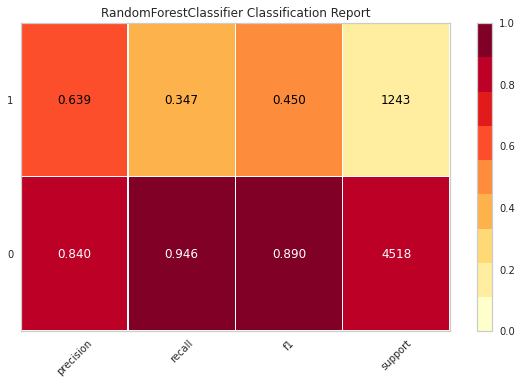

In [102]:
plot_model(tuned_orig_rf[0], plot='class_report')

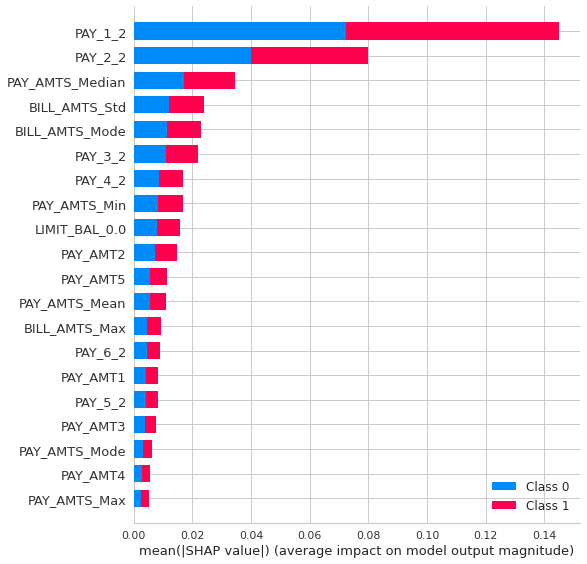

In [103]:
interpret_model(tuned_orig_rf[0])

In [104]:
predict_model(tuned_orig_rf[0])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8169,0.7695,0.3467,0.6395,0.4497,0.3512,0.3749


,PAY_6_3,PAY_5_-1,AGE_7.0,MARRIAGE_2,LIMIT_BAL_1.0,PAY_5_-2,LIMIT_BAL_6.0,PAY_4_3,PAY_5_5,PAY_2_6,...,PAY_4_-1,LIMIT_BAL_13.0,PAY_5_2,LIMIT_BAL_9.0,PAY_2_5,AGE_13.0,PAY_4_4,default,Label,Score
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0.6119
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8532
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9048
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.8320
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.8471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5756,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8429
5757,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8526
5758,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8296
5759,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.7333


In [105]:
final_tuned_orig_rf = finalize_model(tuned_orig_rf[0])

In [106]:
unseen_predictions = predict_model(final_tuned_orig_rf, data=credit_orig_test)
check_metric(unseen_predictions['default'], unseen_predictions['Label'], metric = 'Accuracy')

0.8183

In [108]:
check_metric(unseen_predictions['default'], unseen_predictions['Label'], metric = 'F1')

0.4529

In [109]:
check_metric(unseen_predictions['default'], unseen_predictions['Label'], metric = 'AUC')

0.6469

In [111]:
unseen_predictions.groupby('default')['AGE'].count() / len(unseen_predictions)

default
0    0.7775
1    0.2225
Name: AGE, dtype: float64

In [113]:
unseen_predictions.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,Label,Score
0,90000,2,2,2,34,0,0,0,0,0,...,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,0,0.9069
1,100000,2,2,2,23,0,-1,-1,0,0,...,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0,0,0.8458
2,20000,1,1,2,24,0,0,2,2,2,...,19104.0,3200.0,0.0,1500.0,0.0,1650.0,0.0,1,1,0.5477
3,180000,2,1,2,29,1,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.6689
4,130000,2,3,2,39,0,0,0,0,0,...,930.0,3000.0,1537.0,1000.0,2000.0,930.0,33764.0,0,0,0.9201


In [118]:
unseen_predictions[unseen_predictions['default'] != unseen_predictions['Label']].groupby('default')['LIMIT_BAL'].count()/872

default
0    0.18922
1    0.81078
Name: LIMIT_BAL, dtype: float64

#### Notable pain points: 
1. Certain features of Pycaret, ex. pre-processing pipelines, require the raw input data to have identical columns to that of the training dataset --> this will cause an issue anytime that I do any of *my own* pre-processing steps instead of having Pycaret handle everything
2. `setup` can only hold one object at a time inside the notebook - even if you plug in an explicit model to, for instance, a `plot_model` function, it will still return a plot of what's loaded *last* via `setup`
3. For the same reason as above, it is not possible to view multiple Pycaret plots side-by-side/make use of subplots


In [107]:
save_model(final_tuned_orig_rf, 'CreditClassification_AutoFeatures_2021')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='default',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight={}, criterion='gini',
                                         max_depth=8, max_features=1.0,
                                         max_leaf_node